Imports section. You basically neet to install the JupyterLab, MatPlotLib and Pandas libraris. 

**These are the pip commads to install the packes:**<br>
pip install jupyterlab<br>
pip install pandas<br>
pip install matplolib<br>


In [63]:
import datetime
import math
import json
from json import load, dumps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pandas.io.json import json_normalize 



And now the class. The constructor takes a string containing the full filenname of a JSON database you can down load from the WHO website:

https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide

The database will be loaded and kept as a private member. To retrieve the data for an indvidual country you can use the public methods **GetCountryDataByGeoID** or **GetCountryDataByCountryName**. Refer to the JSON file for a list of available GeoIDs and CountryNames. Both methods will return a list of the following fields as a JSON:

**Date** The date of the data
**Country** The name of the country
**GeoID** The GeoID of the country such as FR for France or DE for Germany

**Cases** The number of cases on that day
**CumultativeCases** The accumulated number of cases since the 31.12.2019
**Quotient** The number of cases on the day devided by the number of cases of the previous day
**DoublingTime** The number of days in which the number of cases will be doubled

**Deaths** The number of deaths on the date
**CumultativeDeaths** The accumulated number of deaths since the 31.12.2019 


In [64]:
# a class
class CovidCases:
    # get a subset of fields
    def __GetFields (self, record):
        return {
            "Country": record["countriesAndTerritories"],
            "GeoID": record["geoId"],
            "Date": record["dateRep"],
            "Cases": record["cases"],
            "Deaths": record["deaths"]
        }

    # constructor
    def __init__(self, filename):
        # the database can be downloaded as a JSON from https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
        # open the file and read the 'records'  
        with open(filename) as f:
            self.__db = load(f)["records"]
        # map the subset
        #__db = [GetFields (r) for r in db]
        self.__db = list (map(lambda x : self.__GetFields(x), self.__db))
        # dump the database
        #print(dumps(self.__db))
        
    # get all records 
    def __GetAllRecords(self, f):
        return lambda y: all([x(y) for x in f])

    # add some specific  fields
    def __AddExtraFields(self, subset):
        # the length of the list
        n = len(subset)
        # add a col to the first element having the number of cases
        subset[0].update({'CumultativeCases': int(subset[0]['Cases'])})
        subset[0].update({'CumultativeDeaths': int(subset[0]['Deaths'])})
        # loop through the list starting at index 1
        for x in range (1, n - 1):
            # the cumultative ncases of day n-1
            dayNm1Cum = int(subset[x-1]['CumultativeCases'])
            # the cases of day n
            dayN = int(subset[x]['Cases'])
            # the cumultative cases of day n
            dayNCum = dayNm1Cum + dayN
            subset[x].update({'CumultativeCases':  dayNCum})
            # the quuotient of day(n) / day(n-1)
            if dayNm1Cum != 0:
                subset[x].update({'Quotient':  dayNCum / dayNm1Cum})
            else:
                subset[x].update({'Quotient':  math.nan})
            quotient = float(subset[x]['Quotient'])
            # the doubling time in days
            if quotient != 1.0 and quotient != math.nan:
                subset[x].update({'DoublingTime':  math.log(2) / math.log(quotient)})
            else:
                subset[x].update({'DoublingTime':  math.nan})
            # the cumultative deaths of day n-1
            dayNm1Cum = int(subset[x-1]['CumultativeDeaths'])
            # the deatha of day n
            dayN = int(subset[x]['Deaths'])
            # the cumultative deaths of day n
            dayNCum = dayNm1Cum + dayN
            subset[x].update({'CumultativeDeaths':  dayNCum})    
            #print(subset[x])
        return subset

    # return the list of cases by geoID
    def GetCountryDataByGeoID (self, geoID):
        # specify the filter
        filters = []
        filters.append(lambda r: r["GeoID"] == geoID)
        # apply the filter
        subset = list(filter( self.__GetAllRecords(filters), self.__db)) 
        # reverse the list (1st date on top of the list)
        subset.reverse()
        subset = self.__AddExtraFields(subset)
        return subset

    # return the list of cases by country name
    def GetCountryDataByCountryName (self, countryName):
        # specify the filter
        filters = []
        filters.append(lambda r: r["countriesAndTerritories"] == countryName)
        # apply the filter
        subset = list(filter( self.__GetAllRecords(filters), self.__db)) 
        # reverse the list (1st date on top of the list)
        subset.reverse()
        subset = self.__AddExtraFields(subset)
        return subset



Using the class is pretty simple. Create an instance of the class using the full path to the filename and get the data for a specific country.


In [65]:
# create an instance
covidCases = CovidCases('/Users/martinkersting/Documents/GitHub/Covid-19-analysis/data/db.json')

# modify the country code if required
countryCode = "DE"
# get cases
dataDE = covidCases.GetCountryDataByGeoID(countryCode)

# modify the country code if required
countryCode = "FR"
# get cases
dataFR = covidCases.GetCountryDataByGeoID(countryCode)



Next we want to visualise the data in several diagrams. In a first step we need to concatinate the data fields of different countries that we want to visualise. Be aware of a proper date format in pandas. Next is to select the field that we want to display, indexed by the date having the countriy name as a column.


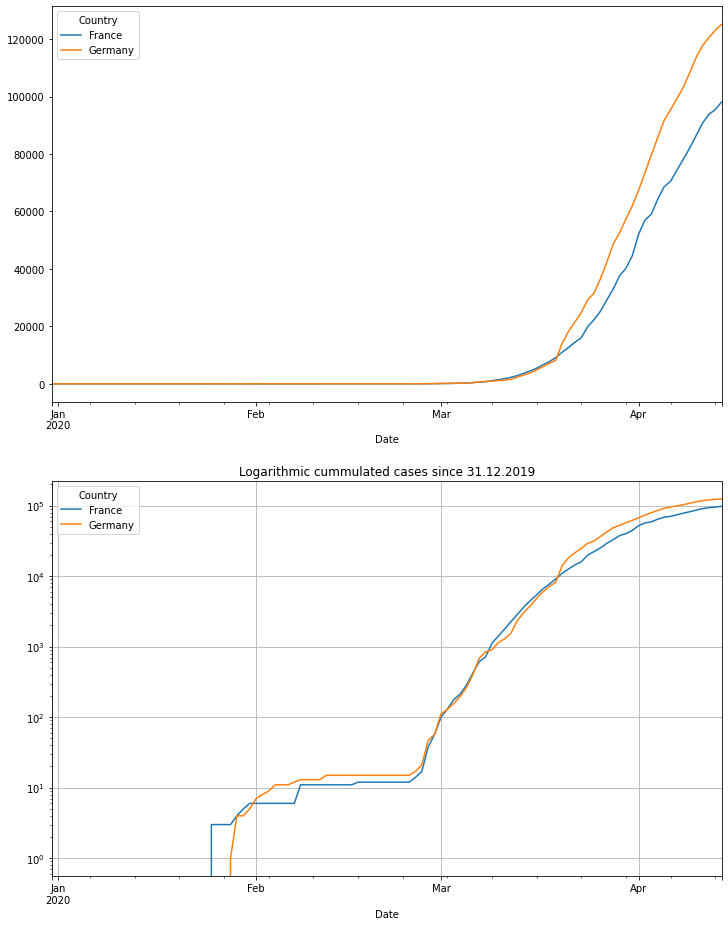

In [72]:
# convert results to a panda dataframes
dfDE = pd.DataFrame(dataDE)
dfFR = pd.DataFrame(dataFR)
# concatinate both lists
df = pd.concat([dfDE, dfFR])
# ensure the type of the 'Date' field
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

# create a multi-index pivot table
mi = df.pivot_table(values = 'CumultativeCases', index = 'Date', columns = 'Country')
# print it
#print(mi)

# plot with various axes scales
fig, ax = plt.subplots(2, 1, figsize = (12,16))
for axis in ax:
    axis.xaxis_date()

# linear commulated cases
mi.plot(ax = ax[0])
plt.yscale('linear')
plt.title('Cummulated cases since 31.12.2019')
plt.grid(True)

# log commulated cases
mi.plot(ax = ax[1])
plt.yscale('log')
plt.title('Logarithmic cummulated cases since 31.12.2019')
plt.grid(True)

plt.show()



The following should be a bargraph (will create an issue):
    

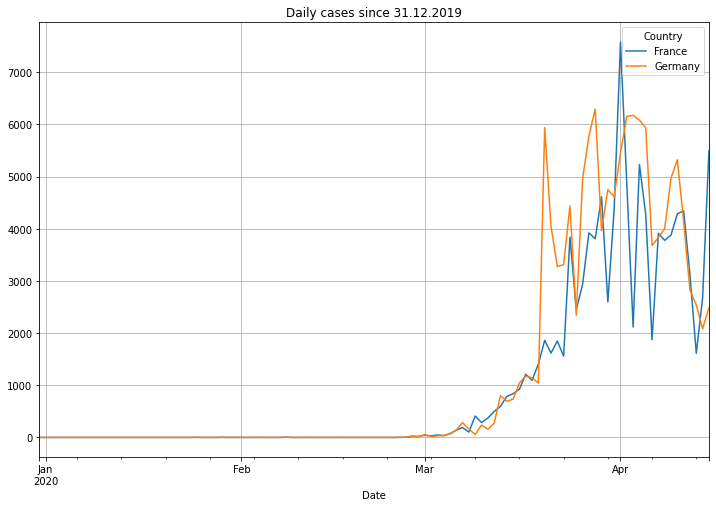

In [67]:
# ensure that cases are of a numeric type
df['Cases'] = pd.to_numeric(df['Cases'])
# create a multi-index pivot table
mi = df.pivot_table(values = 'Cases', index = 'Date', columns = 'Country')
# print it
#print(mi)

# linear commulated cases
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.xaxis_date()
mi.plot(ax = ax)
plt.yscale('linear')
plt.title('Daily cases since 31.12.2019')
plt.grid(True)


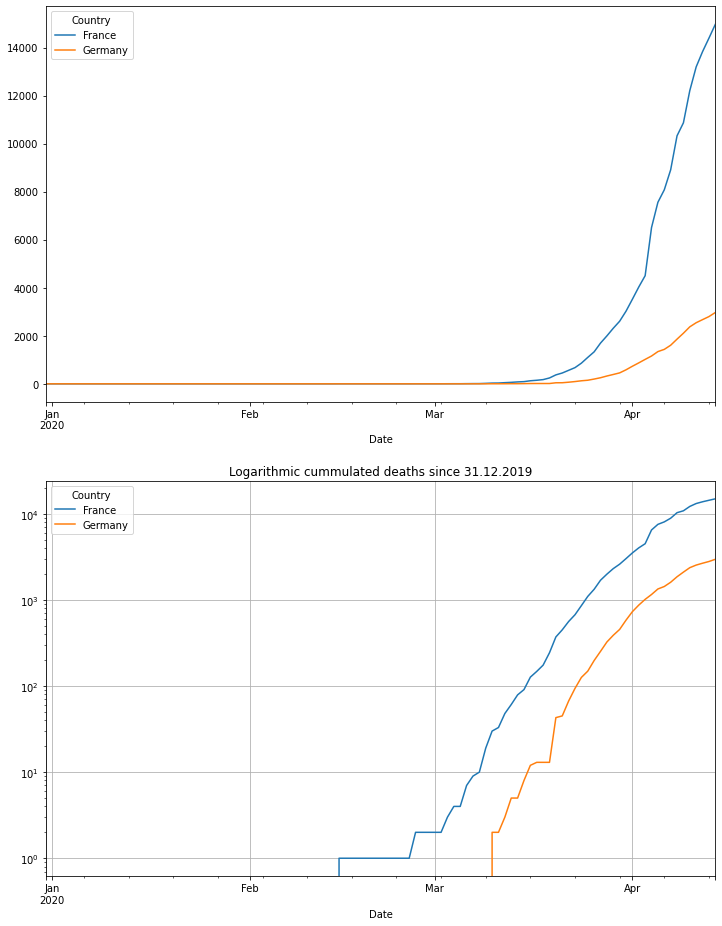

In [68]:
# create a multi-index pivot table
mi = df.pivot_table(values = 'CumultativeDeaths', index = 'Date', columns = 'Country')
# print it
#print(mi)

# plot with various axes scales
fig, ax = plt.subplots(2, 1, figsize = (12,16))
for axis in ax:
    axis.xaxis_date()

# linear commulated deaths
mi.plot(ax = ax[0])
plt.yscale('linear')
plt.title('Cummulated deaths since 31.12.2019')
plt.grid(True)

# log commulated deaths
mi.plot(ax = ax[1])
plt.yscale('log')
plt.title('Logarithmic cummulated deaths since 31.12.2019')
plt.grid(True)


Finally the doubling time:
    

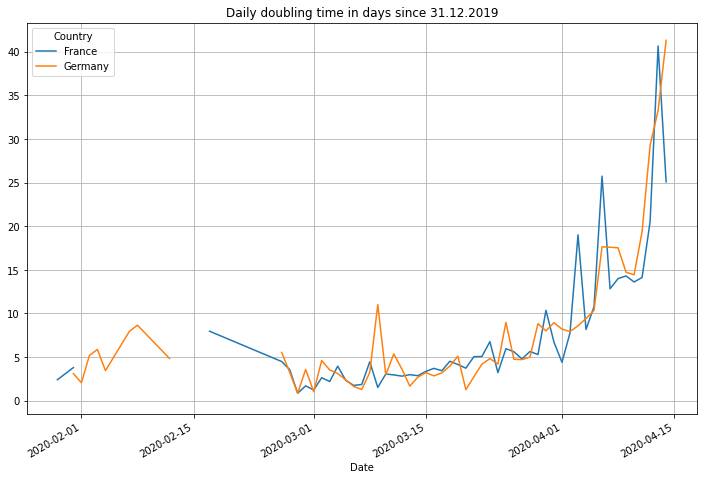

In [62]:
# ensure that cases are of a numeric type
df['DoublingTime'] = pd.to_numeric(df['DoublingTime'])
# create a multi-index pivot table
mi = df.pivot_table(values = 'DoublingTime', index = 'Date', columns = 'Country')
# print it
#print(mi)

# linear commulated cases
fig, ax = plt.subplots(1, 1, figsize = (12,8))
ax.xaxis_date()
mi.plot(ax = ax)
plt.yscale('linear')
plt.title('Daily doubling time in days since 31.12.2019')
plt.grid(True)
